# ​​​​Electricity cost estimator for tomorrow based on weather (i.e. wind, temperature) and past prices​​

This project aims to train a model that can be used to estimate electricity costs based on weather forecasts and historical electricity prices. The model will take into account various weather parameters such as wind speed, temperature, humidity, and other relevant factors that influence electricity generation and consumption.

# 1. Business Understanding

- Goal: Estimate **tomorrow's electricity price** (e.g. day-ahead or hourly) based on historical prices and weather forecasts (temperature, windspeed, humidity).
- Stakeholders: e.g. household, small business, or energy consumer optimizing usage.
- Main questions:
  - How accurately can we predict the electricity prices?
  - At what horizon (next day, next 24 hours hourly) do we predict?

## Success criteria
- Quantitative: e.g. RMSE/MAE below baseline ("tomorrow = today").
- Qualitative: model is simple enough to maintain, features are explainable (e.g. how temperature & wind affect prices).

# 2. Data Understanding – Datasets

We have three main data sources:

- **Price data (15 min)**  
  - Quarter-hour Pörssisähkö prices (`price_ct_per_kwh`).

- **Weather data (hourly, 4 stations)**  
  - `Havaintoasema`, `Vuosi`, `Kuukausi`, `Päivä`, `Aika [UTC]`,  
    `Lämpötilan keskiarvo [°C]`, `Keskituulen nopeus [m/s]`, `Tunnin sademäärä [mm]`.

- **Fingrid power system data**  
  - 15-min: total generation, wind generation.  
  - Hourly: total consumption.  
  - One row per datapoint (time series tagged by variable).

## Sources
- Price data: Pörssisähkö API or CSV export.
- Weather data: Finnish Meteorological Institute (FMI) open data.
- Fingrid data: Fingrid open data CSV export.

The weather data stations are located mainly in western Finland where most wind power is generated as we also take wind generation into account.

# 3. Data Preparation – Raw data to modeling-ready table

In this section we go from three raw data sources:

- Quarter-hour electricity prices
- Hourly weather observations from FMI (4 stations)
- Fingrid power system data (generation and consumption)

to one clean 15‑minute dataset that is ready for feature engineering and modeling.
We proceed step by step and document each transformation.

## 3.1 Load and inspect price data

We start with the Pörssisähkö price data at 15‑minute resolution.

In this step we:

1. Load the CSV into a pandas DataFrame.
2. Parse the `timestamp_utc` column as a timezone-aware datetime.
3. Sort by time and take a quick look at the structure and coverage.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use("seaborn-v0_8")

data_dir = Path("data")
price_file = data_dir / "data_2024-11-22T0000_2025-11-22T0000.csv"

df_prices = (
    pd.read_csv(price_file, parse_dates=["timestamp_utc"])
      .sort_values("timestamp_utc")
      .reset_index(drop=True)
)

print("Price data shape:", df_prices.shape)
print(df_prices.dtypes)
print("Price time range:", df_prices["timestamp_utc"].min(), "→", df_prices["timestamp_utc"].max())
df_prices.head()

Price data shape: (35040, 2)
timestamp_utc       datetime64[ns, UTC]
price_ct_per_kwh                float64
dtype: object
Price time range: 2024-11-22 00:00:00+00:00 → 2025-11-21 23:45:00+00:00


,timestamp_utc,price_ct_per_kwh
0,2024-11-22 00:00:00+00:00,6.941
1,2024-11-22 00:15:00+00:00,6.941
2,2024-11-22 00:30:00+00:00,6.941
3,2024-11-22 00:45:00+00:00,6.941
4,2024-11-22 01:00:00+00:00,7.110


### Explore price time series

Here we draw a quick line plot of the 15‑minute spot prices over the full period.
This helps spot obvious issues such as gaps, extreme spikes or long flat segments.

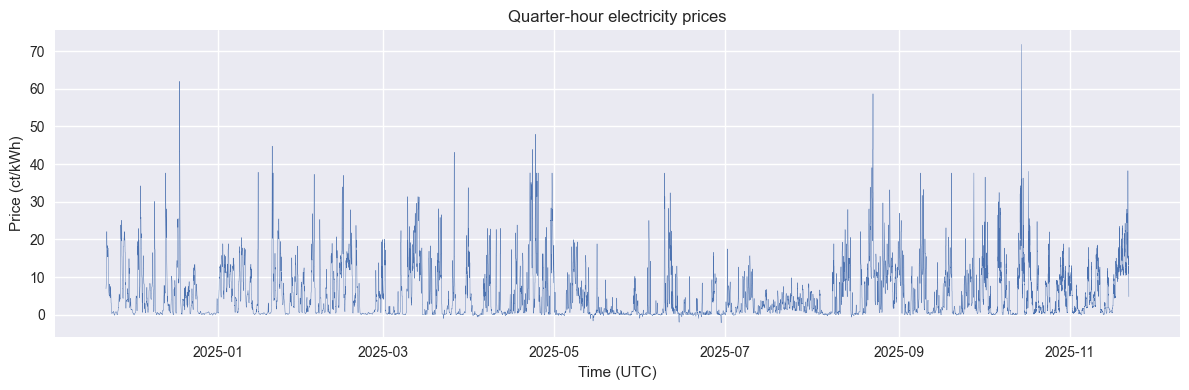

In [3]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df_prices["timestamp_utc"], df_prices["price_ct_per_kwh"], linewidth=0.3)
ax.set_title("Quarter-hour electricity prices")
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Price (ct/kWh)")
plt.tight_layout()
plt.show()

## 3.2 Load raw weather data from FMI

FMI weather files have an unusual layout:

- The first row contains all column names as a single comma-separated string.
- Each data row is also stored as a single comma-separated string in the first column.

For each station file we:

1. Read the file as plain text rows without a header.
2. Parse the header row into individual column names.
3. Split each data line into separate columns.
4. Attach a `source_file` column and concatenate all stations into one table.

In [4]:
import pandas as pd
from pathlib import Path

data_dir = Path("data")

weather_files = [
    "Helsinki Kaisaniemi_ 22.11.2024 - 22.11.2025_3d3d41da-1d45-4c69-bacf-a114a7735389.csv",
    "Oulu lentoasema_ 22.11.2024 - 22.11.2025_f4fdc671-9da3-4780-a90c-f52844de5a3a.csv",
    "Pori lentoasema_ 22.11.2024 - 22.11.2025_71f03ff8-0cde-45a1-b39b-d44c9d5aff05.csv",
    "Vaasa lentoasema_ 22.11.2024 - 22.11.2025_86fe7b3e-156c-40f9-9be4-b2423b9448f5.csv",
]

dfs_weather = []

for fname in weather_files:
    path = data_dir / fname

    # Read raw with no header row; each row is literally the CSV line
    df_raw = pd.read_csv(path, sep=";", header=None, encoding="utf-8", dtype=str)

    # First row contains the real column names as a single string in col 0
    header_str = df_raw.iloc[0, 0]
    parts = [p.strip().strip('"') for p in header_str.split(",")]

    if len(parts) != 8:
        raise ValueError(f"Unexpected weather header format in {fname}: {parts}")

    # Remaining rows contain the data, still as a single string in col 0
    data_lines = df_raw.iloc[1:, 0].tolist()

    # Split each data line on commas, strip quotes, and build a DataFrame
    records = [[p.strip().strip('"') for p in line.split(",")] for line in data_lines]
    df_station = pd.DataFrame(records, columns=parts)

    df_station["source_file"] = fname
    dfs_weather.append(df_station)

df_weather_raw = pd.concat(dfs_weather, ignore_index=True)
print("Combined weather raw shape:", df_weather_raw.shape)
print(df_weather_raw.head())

Combined weather raw shape: (35093, 9)
         Havaintoasema Vuosi Kuukausi Päivä Aika [UTC]  \
0  Helsinki Kaisaniemi  2024       11    22      00:00   
1  Helsinki Kaisaniemi  2024       11    22      01:00   
2  Helsinki Kaisaniemi  2024       11    22      02:00   
3  Helsinki Kaisaniemi  2024       11    22      03:00   
4  Helsinki Kaisaniemi  2024       11    22      04:00   

  Lämpötilan keskiarvo [°C] Keskituulen nopeus [m/s] Tunnin sademäärä [mm]  \
0                      -0.1                      4.3                   0.1   
1                         0                      3.4                   0.4   
2                       0.2                      6.1                     0   
3                      -0.5                      5.8                   0.1   
4                      -0.9                      5.1                     0   

                                         source_file  
0  Helsinki Kaisaniemi_ 22.11.2024 - 22.11.2025_3...  
1  Helsinki Kaisaniemi_ 22.11.202

### Rename columns and construct timestamps

The combined raw weather table still uses Finnish column names and separate
`year`, `month`, `day`, and time fields.

Here we:

- Rename columns to simpler English names (`station`, `temp_avg_c`, `wind_speed_ms`, `rain_mm`, …).
- Build a proper `timestamp_utc` by combining year, month, day and time.
- Keep only the fields needed for analysis and sort by time.

In [5]:
# Rename to simpler names
df_weather = df_weather_raw.rename(columns={
    "Havaintoasema": "station",
    "Vuosi": "year",
    "Kuukausi": "month",
    "Päivä": "day",
    "Aika [UTC]": "time_utc_str",
    "Lämpötilan keskiarvo [°C]": "temp_avg_c",
    "Keskituulen nopeus [m/s]": "wind_speed_ms",
    "Tunnin sademäärä [mm]": "rain_mm",
})

# Build timestamp_utc
dt_str = (
    df_weather["year"].astype(int).astype(str) + "-" +
    df_weather["month"].astype(int).astype(str).str.zfill(2) + "-" +
    df_weather["day"].astype(int).astype(str).str.zfill(2) + " " +
    df_weather["time_utc_str"].astype(str)
)

df_weather["timestamp_utc"] = pd.to_datetime(dt_str, utc=True, errors="coerce")

# Keep only needed cols
df_weather = (
    df_weather[["timestamp_utc", "station", "temp_avg_c", "wind_speed_ms", "rain_mm"]]
    .dropna(subset=["timestamp_utc"])
    .sort_values("timestamp_utc")
    .reset_index(drop=True)
)

print("After timestamp creation:", df_weather.shape)
df_weather.head()

After timestamp creation: (35093, 5)


,timestamp_utc,station,temp_avg_c,wind_speed_ms,rain_mm
0,2024-11-22 00:00:00+00:00,Helsinki Kaisaniemi,-0.1,4.3,0.1
1,2024-11-22 00:00:00+00:00,Oulu lentoasema,-2.7,5.6,-
2,2024-11-22 00:00:00+00:00,Vaasa lentoasema,-1.9,3,-
3,2024-11-22 00:00:00+00:00,Pori lentoasema,-0.9,3.7,-
4,2024-11-22 01:00:00+00:00,Vaasa lentoasema,-1.9,3.3,-


### Clean strange numeric values in weather data

Some weather cells contain messy strings (e.g. multiple numbers glued together).
To make the data usable we:

1. Replace obvious junk (empty strings, `-`, `NaN`) with missing values.
2. Apply a helper function that tries to parse each cell as a float.
3. If direct parsing fails, extract the last numeric substring from the string.
4. Convert temperature, wind and rainfall columns into numeric dtype.

This gives us clean numeric weather features for aggregation.

In [6]:
# Clean and convert weather value columns to numeric
for col in ["temp_avg_c", "wind_speed_ms", "rain_mm"]:
    # Replace empty strings and obvious junk with NaN
    df_weather[col] = df_weather[col].replace(["", "-", "NaN", "nan"], pd.NA)

    # If there are concatenated values like "-0.1-2.7-1.9-0.9",
    # take the last numeric token (you can also choose first or average if you prefer)
    def fix_cell(val):
        if pd.isna(val):
            return pd.NA
        s = str(val).strip()
        # split on non-digit / minus / decimal characters
        parts = [p for p in s.replace(",", ".").split() if p]
        # fall back: try to parse the whole string; if that fails, extract the last numeric-like run
        try:
            return float(s.replace(",", "."))
        except ValueError:
            # crude extraction of last numeric substring
            nums = []
            cur = ""
            for ch in s:
                if ch.isdigit() or ch in "-.":
                    cur += ch
                else:
                    if cur:
                        nums.append(cur)
                        cur = ""
            if cur:
                nums.append(cur)
            if not nums:
                return pd.NA
            try:
                return float(nums[-1])
            except ValueError:
                return pd.NA

    df_weather[col] = df_weather[col].apply(fix_cell)
    df_weather[col] = pd.to_numeric(df_weather[col], errors="coerce")

### Aggregate weather across stations to hourly series

We now collapse the station-level observations into a single time series.

At each UTC hour we take the mean across all four stations for:

- `temp_avg_c`
- `wind_speed_ms`
- `rain_mm`

This yields a clean hourly weather dataset representing the “average Finland”
conditions for our modeling purposes.

In [7]:
df_weather_hourly = (
    df_weather
    .groupby("timestamp_utc", as_index=False)
    .agg({
        "temp_avg_c": "mean",
        "wind_speed_ms": "mean",
        "rain_mm": "mean",
    })
    .sort_values("timestamp_utc")
    .reset_index(drop=True)
)

print("Aggregated hourly weather shape:", df_weather_hourly.shape)
df_weather_hourly.head()

Aggregated hourly weather shape: (8775, 4)


,timestamp_utc,temp_avg_c,wind_speed_ms,rain_mm
0,2024-11-22 00:00:00+00:00,-1.400,4.150,0.1
1,2024-11-22 01:00:00+00:00,-1.300,3.950,0.4
2,2024-11-22 02:00:00+00:00,-1.300,4.525,0.0
3,2024-11-22 03:00:00+00:00,-1.575,4.450,0.1
4,2024-11-22 04:00:00+00:00,-1.650,4.200,0.0


### Visual sanity check for hourly weather

To verify that the aggregated weather looks reasonable, we plot:

1. Hourly average temperature
2. Hourly average wind speed
3. Hourly hourly rainfall

This helps spot discontinuities, missing periods, or outlier values.

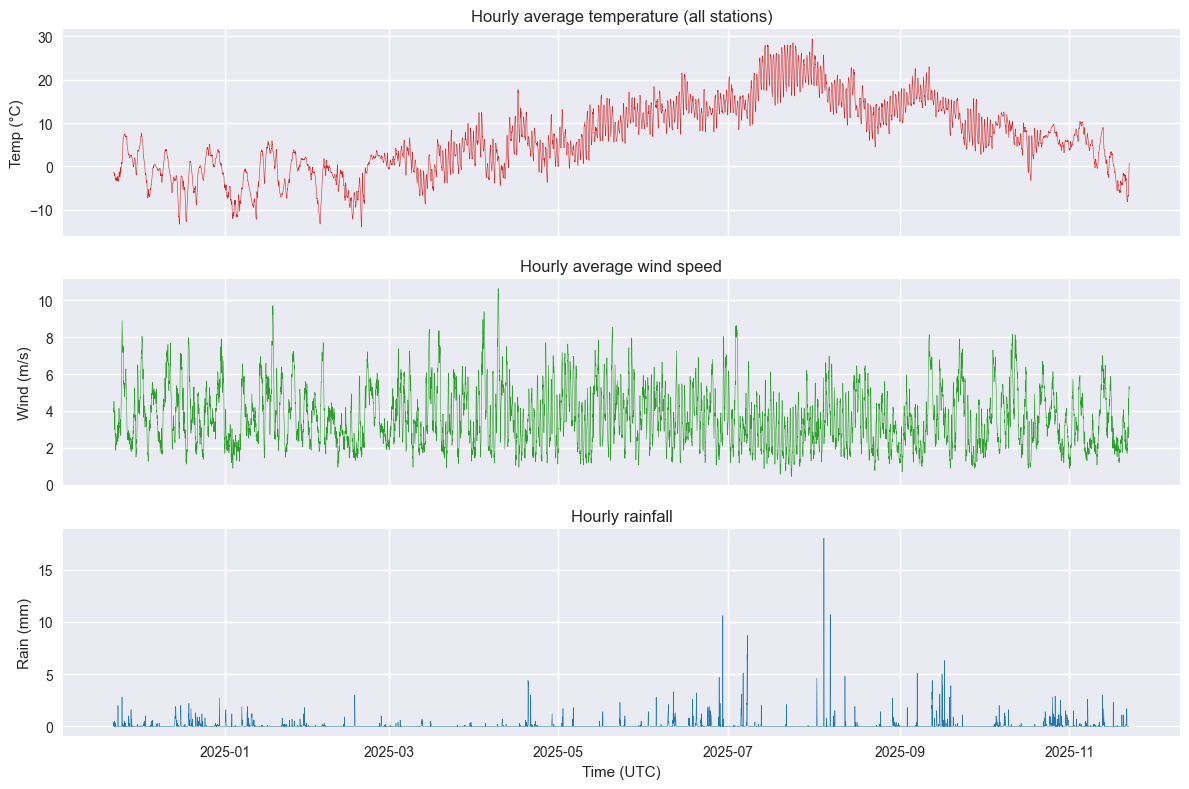

In [8]:
# Quick sanity plots for hourly weather (aggregated across stations)
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axes[0].plot(
    df_weather_hourly["timestamp_utc"],
    df_weather_hourly["temp_avg_c"],
    linewidth=0.4,
    color="tab:red",
)
axes[0].set_ylabel("Temp (°C)")
axes[0].set_title("Hourly average temperature (all stations)")

axes[1].plot(
    df_weather_hourly["timestamp_utc"],
    df_weather_hourly["wind_speed_ms"],
    linewidth=0.4,
    color="tab:green",
)
axes[1].set_ylabel("Wind (m/s)")
axes[1].set_title("Hourly average wind speed")

axes[2].plot(
    df_weather_hourly["timestamp_utc"],
    df_weather_hourly["rain_mm"],
    linewidth=0.4,
    color="tab:blue",
)
axes[2].set_ylabel("Rain (mm)")
axes[2].set_title("Hourly rainfall")
axes[2].set_xlabel("Time (UTC)")

plt.tight_layout()
plt.show()

### Upsample hourly weather to 15‑minute grid

Electricity prices are at 15‑minute resolution, so we align the weather data.

We:

- Set `timestamp_utc` as the index.
- Resample to 15‑minute frequency.
- Forward-fill within each hour.

This produces a 15‑minute weather table that can be merged directly with prices.

In [9]:
# Upsample hourly weather to 15-minute resolution (forward-fill within the hour)
df_weather_15min = (
    df_weather_hourly
    .set_index("timestamp_utc")
    .resample("15min")
    .ffill()
    .reset_index()
)

print("15-min weather shape:", df_weather_15min.shape)
df_weather_15min.head()

15-min weather shape: (35097, 4)


,timestamp_utc,temp_avg_c,wind_speed_ms,rain_mm
0,2024-11-22 00:00:00+00:00,-1.4,4.15,0.1
1,2024-11-22 00:15:00+00:00,-1.4,4.15,0.1
2,2024-11-22 00:30:00+00:00,-1.4,4.15,0.1
3,2024-11-22 00:45:00+00:00,-1.4,4.15,0.1
4,2024-11-22 01:00:00+00:00,-1.3,3.95,0.4


## 3.3 Combine prices and weather on 15‑minute grid

Here we merge the 15‑minute price series with the 15‑minute weather series
on `timestamp_utc` using a left join.

The result `df_price_weather` has, for each 15‑minute interval:

- `price_ct_per_kwh`
- `temp_avg_c`
- `wind_speed_ms`
- `rain_mm`

In [10]:
# Merge 15-min price data with 15-min weather data
df_price_weather = df_prices.merge(
    df_weather_15min,
    on="timestamp_utc",
    how="left",
)

print("Price + weather shape:", df_price_weather.shape)
df_price_weather.head()

Price + weather shape: (35040, 5)


,timestamp_utc,price_ct_per_kwh,temp_avg_c,wind_speed_ms,rain_mm
0,2024-11-22 00:00:00+00:00,6.941,-1.4,4.15,0.1
1,2024-11-22 00:15:00+00:00,6.941,-1.4,4.15,0.1
2,2024-11-22 00:30:00+00:00,6.941,-1.4,4.15,0.1
3,2024-11-22 00:45:00+00:00,6.941,-1.4,4.15,0.1
4,2024-11-22 01:00:00+00:00,7.110,-1.3,3.95,0.4


### Zoomed view: price vs. weather

To better understand short-term relationships, we zoom into a one-week window.

We:

1. Filter `df_price_weather` to a chosen week.
2. Plot four aligned panels:

   - Price
   - Temperature
   - Wind speed
   - Rainfall

This gives an intuitive feel for how price moves together with weather.

Zoomed range: 2025-01-01 00:00:00+00:00 → 2025-01-07 23:45:00+00:00
Zoomed shape: (672, 5)


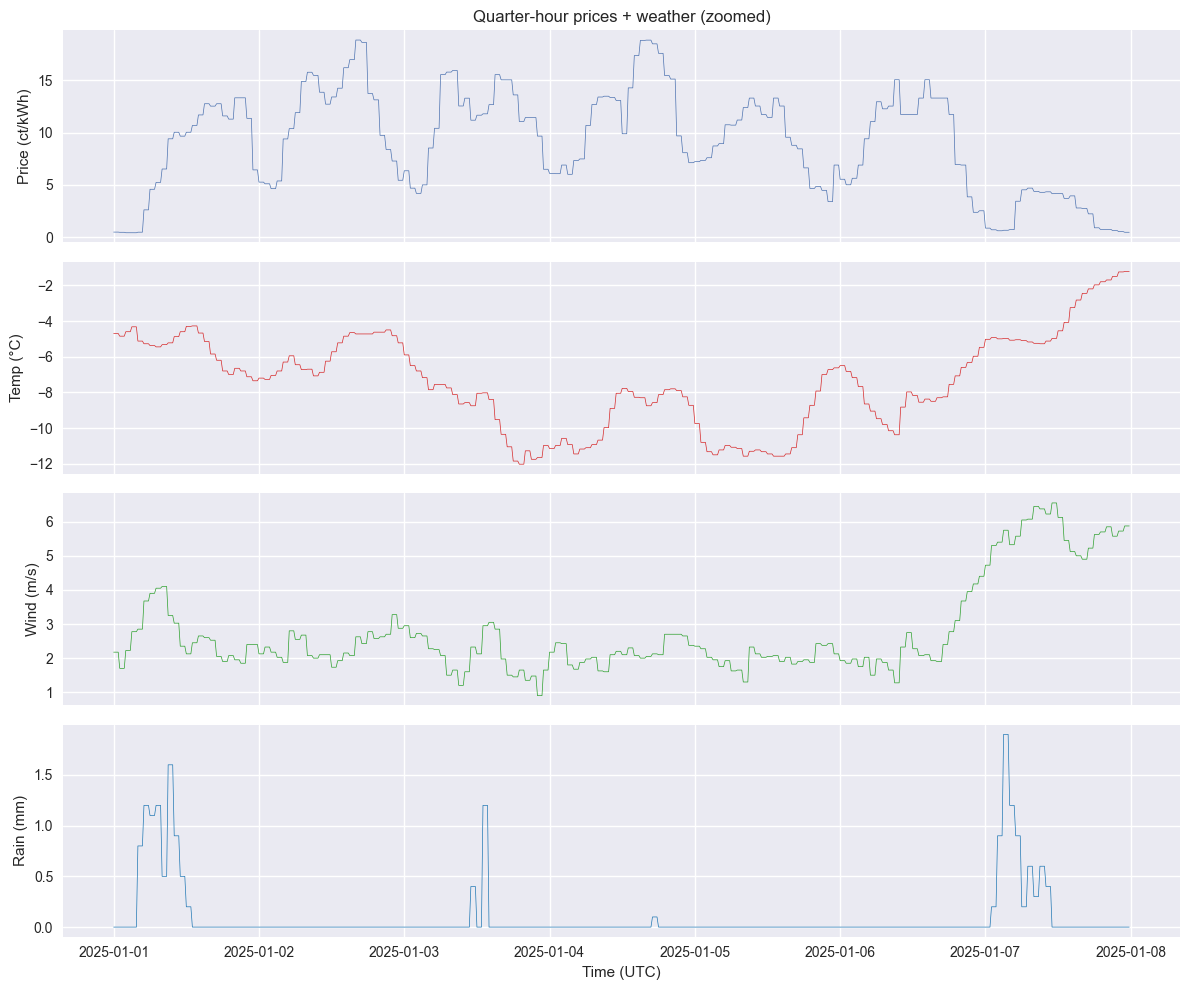

In [11]:
# Pick a smaller time window to zoom in
start_zoom = pd.Timestamp("2025-01-01", tz="UTC")
end_zoom   = pd.Timestamp("2025-01-08", tz="UTC")

mask = (df_price_weather["timestamp_utc"] >= start_zoom) & (
    df_price_weather["timestamp_utc"] < end_zoom
)
df_zoom = df_price_weather.loc[mask].copy()

print("Zoomed range:", df_zoom["timestamp_utc"].min(), "→", df_zoom["timestamp_utc"].max())
print("Zoomed shape:", df_zoom.shape)

fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# 1) Price
axes[0].plot(
    df_zoom["timestamp_utc"],
    df_zoom["price_ct_per_kwh"],
    linewidth=0.5,
)
axes[0].set_ylabel("Price (ct/kWh)")
axes[0].set_title("Quarter-hour prices + weather (zoomed)")

# 2) Temperature
axes[1].plot(
    df_zoom["timestamp_utc"],
    df_zoom["temp_avg_c"],
    linewidth=0.5,
    color="tab:red",
)
axes[1].set_ylabel("Temp (°C)")

# 3) Wind
axes[2].plot(
    df_zoom["timestamp_utc"],
    df_zoom["wind_speed_ms"],
    linewidth=0.5,
    color="tab:green",
)
axes[2].set_ylabel("Wind (m/s)")

# 4) Rain
axes[3].plot(
    df_zoom["timestamp_utc"],
    df_zoom["rain_mm"],
    linewidth=0.5,
    color="tab:blue",
)
axes[3].set_ylabel("Rain (mm)")
axes[3].set_xlabel("Time (UTC)")

plt.tight_layout()
plt.show()

## 3.4 Load Fingrid power system data

Next we bring in Fingrid data describing the power system state.

The CSV contains one row per measurement with:

- `datasetId` (which variable),
- `startTime` and `endTime`,
- `value`,
- `additionalJson` (extra metadata).

We load the file using the correct separator (`;`) and inspect its structure.

In [12]:
from pathlib import Path

fingrid_file = data_dir / "fingrid_data_2024-11-22T0000_2025-11-22T0000.csv"

# First attempt: semicolon-separated, common for Fingrid exports
df_fingrid = pd.read_csv(
    fingrid_file,
    sep=";",
    engine="python",
    encoding="utf-8",
)

print("Fingrid raw shape:", df_fingrid.shape)
print(df_fingrid.columns.tolist())
df_fingrid.head(10)

Fingrid raw shape: (78606, 5)
['datasetId', 'startTime', 'endTime', 'value', 'additionalJson']


,datasetId,startTime,endTime,value,additionalJson
0,74,2025-11-21T21:45:00.000Z,2025-11-21T22:00:00.000Z,9758.23,NaN
1,75,2025-11-21T21:45:00.000Z,2025-11-21T22:00:00.000Z,1540.09,NaN
2,74,2025-11-21T21:30:00.000Z,2025-11-21T21:45:00.000Z,9715.73,NaN
3,75,2025-11-21T21:30:00.000Z,2025-11-21T21:45:00.000Z,1493.92,NaN
4,74,2025-11-21T21:15:00.000Z,2025-11-21T21:30:00.000Z,9783.39,NaN
5,75,2025-11-21T21:15:00.000Z,2025-11-21T21:30:00.000Z,1433.79,NaN
6,74,2025-11-21T21:00:00.000Z,2025-11-21T21:15:00.000Z,9878.06,NaN
7,75,2025-11-21T21:00:00.000Z,2025-11-21T21:15:00.000Z,1396.43,NaN
8,74,2025-11-21T20:45:00.000Z,2025-11-21T21:00:00.000Z,9766.63,NaN
9,75,2025-11-21T20:45:00.000Z,2025-11-21T21:00:00.000Z,1371.36,NaN


### Parse Fingrid timestamps and values

We reshape the raw Fingrid table into a cleaner time series format:

1. Copy the raw DataFrame.
2. Parse `startTime` into a timezone-aware `timestamp_utc` (start of 15‑min or 1‑hour period).
3. Convert `value` to numeric, coercing bad rows to NaN.
4. Drop rows with missing timestamps or values.

This gives us a cleaned long-form table ready to be split by variable.

In [13]:
# Parse timestamps and keep core columns
df_fingrid_clean = df_fingrid.copy()

# Use startTime as the time stamp (it’s a 15-min or 1-hour period start)
df_fingrid_clean["timestamp_utc"] = pd.to_datetime(
    df_fingrid_clean["startTime"], utc=True, errors="coerce"
)

# Make sure value is numeric
df_fingrid_clean["value"] = pd.to_numeric(df_fingrid_clean["value"], errors="coerce")

# Drop rows without a timestamp or value
df_fingrid_clean = df_fingrid_clean.dropna(subset=["timestamp_utc", "value"])

print("After basic cleaning:", df_fingrid_clean.shape)
df_fingrid_clean.head()

After basic cleaning: (78606, 6)


,datasetId,startTime,endTime,value,additionalJson,timestamp_utc
0,74,2025-11-21T21:45:00.000Z,2025-11-21T22:00:00.000Z,9758.23,NaN,2025-11-21 21:45:00+00:00
1,75,2025-11-21T21:45:00.000Z,2025-11-21T22:00:00.000Z,1540.09,NaN,2025-11-21 21:45:00+00:00
2,74,2025-11-21T21:30:00.000Z,2025-11-21T21:45:00.000Z,9715.73,NaN,2025-11-21 21:30:00+00:00
3,75,2025-11-21T21:30:00.000Z,2025-11-21T21:45:00.000Z,1493.92,NaN,2025-11-21 21:30:00+00:00
4,74,2025-11-21T21:15:00.000Z,2025-11-21T21:30:00.000Z,9783.39,NaN,2025-11-21 21:15:00+00:00


### Inspect available Fingrid series (datasetId)

Before mapping `datasetId` to human-readable names, we check which IDs appear
and how many rows each has. This tells us:

- Which variables are included in this export.
- What their native resolution is (15‑minute vs hourly) based on timestamp spacing.

In [14]:
df_fingrid_clean["datasetId"].value_counts()

datasetId
74     34949
75     34943
363     8714
Name: count, dtype: int64

### Map dataset IDs and pivot to wide format

Based on the `datasetId` frequencies, we identify three key series:

- `74`  → total generation (`gen_total_mw`, 15‑minute),
- `75`  → wind generation (`gen_wind_mw`, 15‑minute),
- `363` → total consumption (`cons_total_mw`, hourly).

We:

1. Filter the cleaned Fingrid table to these IDs.
2. Map each `datasetId` to a readable `series` name.
3. Pivot from long → wide so each timestamp has columns:

   - `gen_total_mw`
   - `gen_wind_mw`
   - `cons_total_mw`

In [15]:
# Map datasetId → human-readable column name.
# UPDATE THESE IDs based on the value_counts output.
dataset_id_to_name = {
    74: "gen_total_mw",
    75: "gen_wind_mw",
    363: "cons_total_mw",
}

# Filter only the IDs you care about
df_fingrid_sel = df_fingrid_clean[
    df_fingrid_clean["datasetId"].isin(dataset_id_to_name.keys())
].copy()

# Replace datasetId with readable names
df_fingrid_sel["series"] = df_fingrid_sel["datasetId"].map(dataset_id_to_name)

# Pivot to wide: one row per timestamp, columns per series
df_fingrid_wide = df_fingrid_sel.pivot_table(
    index="timestamp_utc",
    columns="series",
    values="value",
    aggfunc="mean",
).sort_index()

df_fingrid_wide = df_fingrid_wide.reset_index()

print("Wide Fingrid shape:", df_fingrid_wide.shape)
df_fingrid_wide.head()

Wide Fingrid shape: (34967, 4)


series,timestamp_utc,cons_total_mw,gen_total_mw,gen_wind_mw
0,2024-11-21 22:00:00+00:00,6341537.654,10281.6,3833.74
1,2024-11-21 22:15:00+00:00,NaN,10254.4,3847.29
2,2024-11-21 22:30:00+00:00,NaN,10220.1,3858.16
3,2024-11-21 22:45:00+00:00,NaN,10128.4,3753.78
4,2024-11-21 23:00:00+00:00,6063308.210,10195.4,3701.63


### Align Fingrid generation and consumption to 15‑minute grid

Generation series are naturally at 15‑minute resolution, whereas total
consumption is hourly.

To have a consistent 15‑minute grid we:

- Keep `gen_total_mw` and `gen_wind_mw` at 15‑minute resolution.
- Resample hourly `cons_total_mw` to 15‑minute and forward‑fill within the hour.
- Merge the series back together into `df_fingrid_15min`.

In [16]:
# Separate 15-min series (generation) and hourly series (consumption)
df_fingrid_15_src = df_fingrid_wide[["timestamp_utc", "gen_total_mw", "gen_wind_mw"]].copy()

# Upsample hourly consumption to 15-min and forward-fill within the hour
df_fingrid_cons_15 = (
    df_fingrid_wide[["timestamp_utc", "cons_total_mw"]]
    .set_index("timestamp_utc")
    .resample("15min")
    .ffill()
    .reset_index()
)

# Merge them back together on timestamp_utc
df_fingrid_15min = df_fingrid_15_src.merge(
    df_fingrid_cons_15,
    on="timestamp_utc",
    how="left",
)

print("Fingrid 15-min shape:", df_fingrid_15min.shape)
df_fingrid_15min.head()

Fingrid 15-min shape: (34967, 4)


series,timestamp_utc,gen_total_mw,gen_wind_mw,cons_total_mw
0,2024-11-21 22:00:00+00:00,10281.6,3833.74,6341537.654
1,2024-11-21 22:15:00+00:00,10254.4,3847.29,NaN
2,2024-11-21 22:30:00+00:00,10220.1,3858.16,NaN
3,2024-11-21 22:45:00+00:00,10128.4,3753.78,NaN
4,2024-11-21 23:00:00+00:00,10195.4,3701.63,6063308.210


## 3.5 Build the full modeling dataset

We now combine all three data sources:

- `df_price_weather`: prices + weather at 15‑minute resolution.
- `df_fingrid_15min`: generation and (upsampled) consumption at 15‑minute resolution.

We left‑join on `timestamp_utc` to produce `df_full`, which has, for each 15‑minute slot:

- Price
- Weather features
- Power system features (generation and consumption)

In [17]:
df_full = df_price_weather.merge(
    df_fingrid_15min,
    on="timestamp_utc",
    how="left",
)

print("Full dataset shape (price + weather + generation):", df_full.shape)
df_full.head()

Full dataset shape (price + weather + generation): (35040, 8)


,timestamp_utc,price_ct_per_kwh,temp_avg_c,wind_speed_ms,rain_mm,gen_total_mw,gen_wind_mw,cons_total_mw
0,2024-11-22 00:00:00+00:00,6.941,-1.4,4.15,0.1,10038.60,3671.70,5901238.656
1,2024-11-22 00:15:00+00:00,6.941,-1.4,4.15,0.1,9983.39,3617.88,NaN
2,2024-11-22 00:30:00+00:00,6.941,-1.4,4.15,0.1,9961.96,3571.76,NaN
3,2024-11-22 00:45:00+00:00,6.941,-1.4,4.15,0.1,9959.98,3485.85,NaN
4,2024-11-22 01:00:00+00:00,7.110,-1.3,3.95,0.4,9894.21,3383.98,5791259.761


### Handle small gaps and final sanity check

Some timestamps have missing Fingrid values due to resampling and joins.

For visualization and modeling we:

- Sort `df_full` by time.
- Forward‑ and backward‑fill small gaps in `gen_total_mw`, `gen_wind_mw`,
  and `cons_total_mw`.

Then we plot a one‑week zoom showing:

1. Price
2. Temperature
3. Wind speed
4. Rainfall
5. Total generation
6. Total consumption

as a final sanity check before defining the prediction target and features.

gen_total_mw     0.0
gen_wind_mw      0.0
cons_total_mw    0.0
dtype: float64
Zoom non-null consumption rows: 672


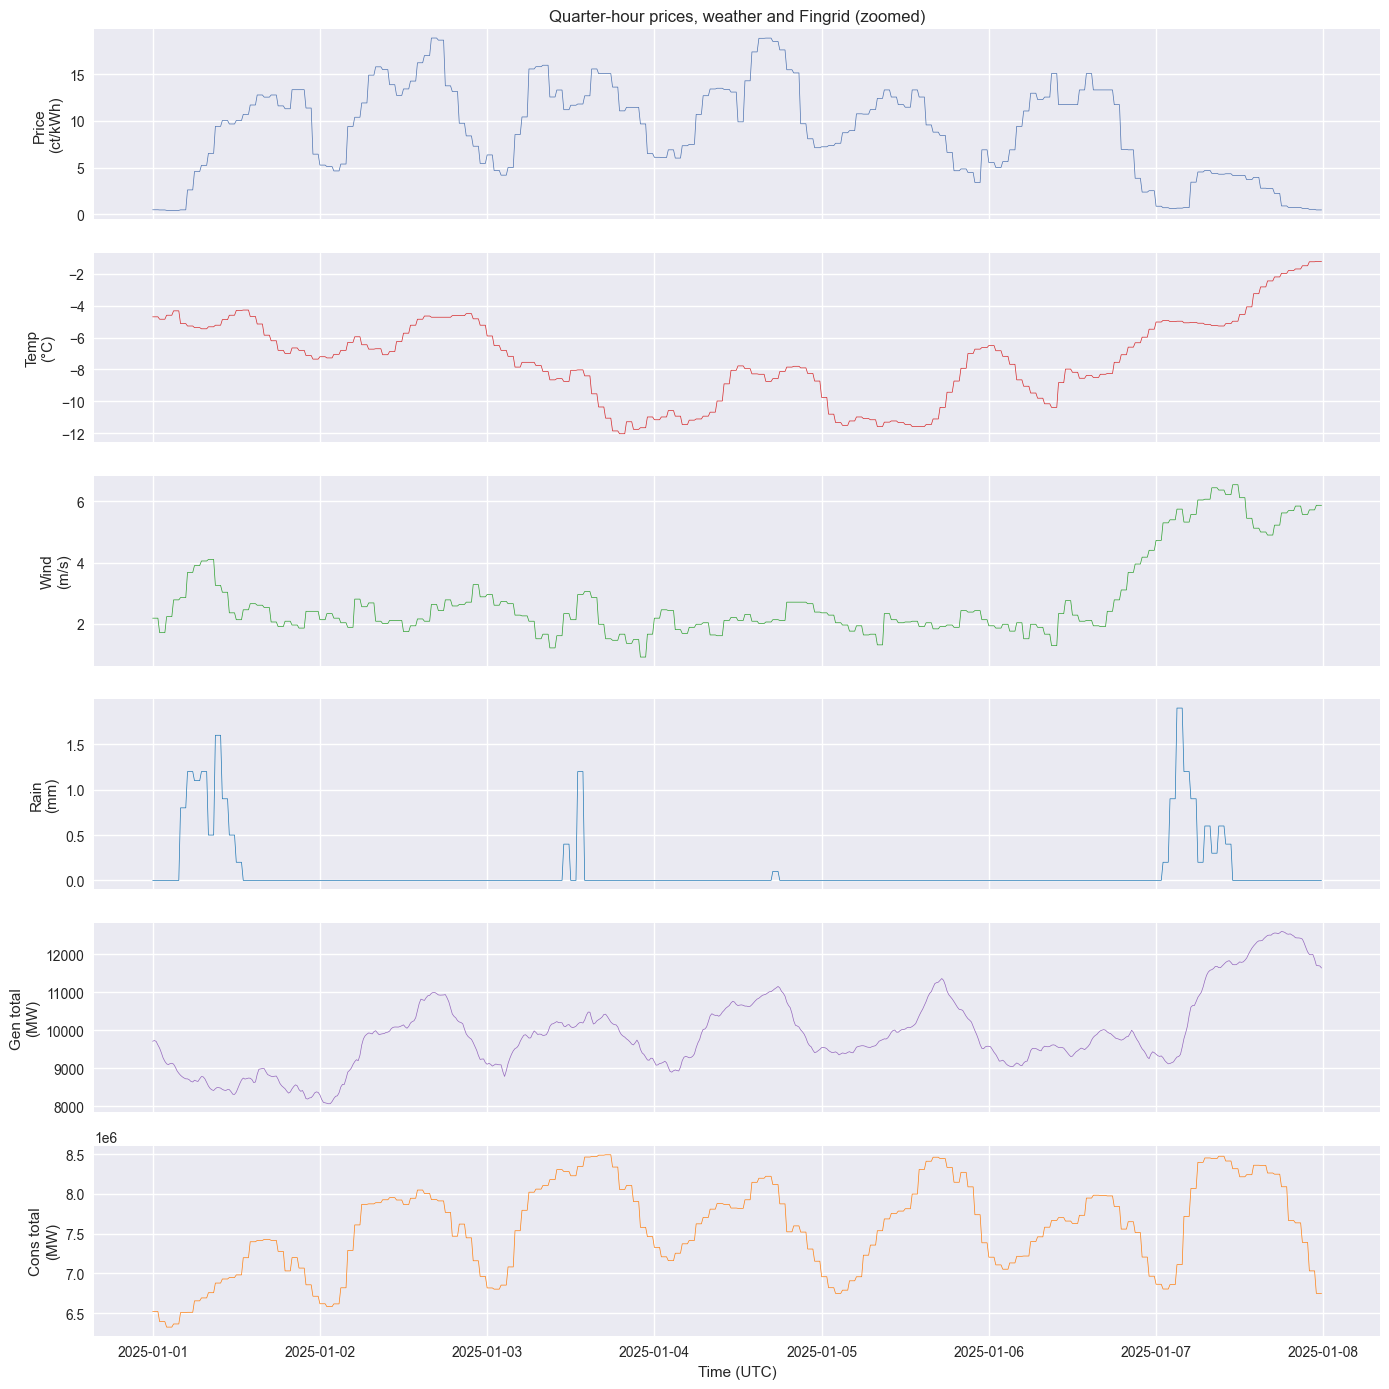

In [18]:
# Fill consumption and generation gaps for visualization / modeling
df_full = df_full.sort_values("timestamp_utc").reset_index(drop=True)

for col in ["gen_total_mw", "gen_wind_mw", "cons_total_mw"]:
    # First forward/backward fill as before
    df_full[col] = df_full[col].ffill().bfill()
    # If there are still any NaNs (e.g. at extreme edges), fill with global median
    if df_full[col].isna().any():
        df_full[col] = df_full[col].fillna(df_full[col].median())

print(df_full[["gen_total_mw", "gen_wind_mw", "cons_total_mw"]].isna().mean())

# Rebuild zoomed view (same dates as before)
start_zoom = pd.Timestamp("2025-01-01", tz="UTC")
end_zoom   = pd.Timestamp("2025-01-08", tz="UTC")

mask = (df_full["timestamp_utc"] >= start_zoom) & (df_full["timestamp_utc"] < end_zoom)
df_zoom_full = df_full.loc[mask].copy()

print("Zoom non-null consumption rows:", df_zoom_full["cons_total_mw"].notna().sum())

fig, axes = plt.subplots(6, 1, figsize=(14, 14), sharex=True)

axes[0].plot(df_zoom_full["timestamp_utc"], df_zoom_full["price_ct_per_kwh"], linewidth=0.5)
axes[0].set_ylabel("Price\n(ct/kWh)")
axes[0].set_title("Quarter-hour prices, weather and Fingrid (zoomed)")

axes[1].plot(df_zoom_full["timestamp_utc"], df_zoom_full["temp_avg_c"], linewidth=0.5, color="tab:red")
axes[1].set_ylabel("Temp\n(°C)")

axes[2].plot(df_zoom_full["timestamp_utc"], df_zoom_full["wind_speed_ms"], linewidth=0.5, color="tab:green")
axes[2].set_ylabel("Wind\n(m/s)")

axes[3].plot(df_zoom_full["timestamp_utc"], df_zoom_full["rain_mm"], linewidth=0.5, color="tab:blue")
axes[3].set_ylabel("Rain\n(mm)")

axes[4].plot(df_zoom_full["timestamp_utc"], df_zoom_full["gen_total_mw"], linewidth=0.5, color="tab:purple")
axes[4].set_ylabel("Gen total\n(MW)")

axes[5].plot(df_zoom_full["timestamp_utc"], df_zoom_full["cons_total_mw"], linewidth=0.5, color="tab:orange")
axes[5].set_ylabel("Cons total\n(MW)")
axes[5].set_xlabel("Time (UTC)")

plt.tight_layout()
plt.show()

## 4. Modeling – Target and features

With the full 15‑minute dataset ready, we now:

1. Define the prediction target (e.g. next 1‑hour price or next 15‑minute price).
2. Engineer features (lags, rolling averages, calendar features, weather and Fingrid signals).
3. Split the data into train and validation periods.
4. Train and evaluate a first regression model against a naïve baseline.

In [19]:
# 4.1 Define prediction target and basic features

# We assume df_full already exists and is cleaned
df_model = df_full.copy()

# Ensure time is sorted and set index for convenience
df_model = df_model.sort_values("timestamp_utc").reset_index(drop=True)
df_model = df_model.set_index("timestamp_utc")

# --- Target: next 1-hour average price (4x 15-min ahead) ---

# Rolling mean of the next 4 quarters as the future 1h price
# We shift by -4 to look forward in time
df_model["target_price_1h_ahead"] = (
    df_model["price_ct_per_kwh"]
    .rolling(window=4, min_periods=4)
    .mean()
    .shift(-4)
)

# --- Price history features (lags and rolling means) ---

# Simple lags: last 4 quarters (1 hour)
for lag in [1, 2, 3, 4]:
    df_model[f"price_lag_{lag}"] = df_model["price_ct_per_kwh"].shift(lag)

# Rolling mean of past 1h (4 quarters) and 4h (16 quarters)
df_model["price_roll_mean_1h"] = (
    df_model["price_ct_per_kwh"].rolling(window=4, min_periods=4).mean()
)
df_model["price_roll_mean_4h"] = (
    df_model["price_ct_per_kwh"].rolling(window=16, min_periods=8).mean()
)

# --- Weather and Fingrid lags (short-term history) ---

for col in ["temp_avg_c", "wind_speed_ms", "rain_mm",
            "gen_total_mw", "gen_wind_mw", "cons_total_mw"]:
    df_model[f"{col}_lag_1"] = df_model[col].shift(1)
    df_model[f"{col}_lag_4"] = df_model[col].shift(4)

# --- Calendar features ---

df_model["hour"] = df_model.index.hour
df_model["dayofweek"] = df_model.index.dayofweek  # 0=Mon, 6=Sun
df_model["is_weekend"] = (df_model["dayofweek"] >= 5).astype(int)

# Drop rows where the target is NaN (end of series) or lags are missing
cols_required = ["target_price_1h_ahead"] + [
    c for c in df_model.columns if c.startswith("price_lag_")
]
df_model = df_model.dropna(subset=cols_required)

# As a final safety step, drop any rows that still have NaNs in any feature
df_model = df_model.dropna()

print("Model dataset shape:", df_model.shape)
df_model.head()

Model dataset shape: (35029, 29)


,price_ct_per_kwh,temp_avg_c,wind_speed_ms,rain_mm,gen_total_mw,gen_wind_mw,cons_total_mw,target_price_1h_ahead,price_lag_1,price_lag_2,...,rain_mm_lag_4,gen_total_mw_lag_1,gen_total_mw_lag_4,gen_wind_mw_lag_1,gen_wind_mw_lag_4,cons_total_mw_lag_1,cons_total_mw_lag_4,hour,dayofweek,is_weekend
timestamp_utc,,,,,,,,,,,,,,,,,,,,,
2024-11-22 01:45:00+00:00,7.110,-1.3,3.950,0.4,9680.88,3140.77,5791259.761,8.37600,7.110,7.110,...,0.1,9758.39,9959.98,3243.51,3485.85,5791259.761,5901238.656,1,4,0
2024-11-22 02:00:00+00:00,8.376,-1.3,4.525,0.0,9698.78,3059.66,5794689.099,8.62475,7.110,7.110,...,0.4,9680.88,9894.21,3140.77,3383.98,5791259.761,5791259.761,2,4,0
2024-11-22 02:15:00+00:00,8.376,-1.3,4.525,0.0,9739.16,2982.32,5794689.099,8.87350,8.376,7.110,...,0.4,9698.78,9758.39,3059.66,3243.51,5794689.099,5791259.761,2,4,0
2024-11-22 02:30:00+00:00,8.376,-1.3,4.525,0.0,9545.45,2766.27,5794689.099,9.12225,8.376,8.376,...,0.4,9739.16,9758.39,2982.32,3243.51,5794689.099,5791259.761,2,4,0
2024-11-22 02:45:00+00:00,8.376,-1.3,4.525,0.0,9416.72,2594.02,5794689.099,9.37100,8.376,8.376,...,0.4,9545.45,9680.88,2766.27,3140.77,5794689.099,5791259.761,2,4,0


### 4.2 Train / validation split and baselines

We now split the modeling dataset into a **training period** and a **validation period**
based on time (no shuffling, to respect temporal order).

We also create a very simple baseline that predicts the future 1‑hour average price
as the **current price** (\"tomorrow = today\" style), and compare our model against it.

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
import numpy as np

# Use all non-target columns as features
feature_cols = [c for c in df_model.columns if c != "target_price_1h_ahead"]

# Choose a time-based split: e.g. last 20% for validation
n = len(df_model)
split_idx = int(n * 0.8)

df_train = df_model.iloc[:split_idx].copy()
df_valid = df_model.iloc[split_idx:].copy()

X_train = df_train[feature_cols]
y_train = df_train["target_price_1h_ahead"]

X_valid = df_valid[feature_cols]
y_valid = df_valid["target_price_1h_ahead"]

print("Train shape:", X_train.shape, "Valid shape:", X_valid.shape)

# --- Baseline: predict future 1h price as current price_ct_per_kwh ---

baseline_train_pred = df_train["price_ct_per_kwh"]
baseline_valid_pred = df_valid["price_ct_per_kwh"]

def print_metrics(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    print(f"{name}  MAE: {mae:.3f}, RMSE: {rmse:.3f}")

print("Baseline performance (future 1h price ≈ current price):")
print_metrics("Train baseline", y_train, baseline_train_pred.loc[y_train.index])
print_metrics("Valid baseline", y_valid, baseline_valid_pred.loc[y_valid.index])

Train shape: (28023, 28) Valid shape: (7006, 28)
Baseline performance (future 1h price ≈ current price):
Train baseline  MAE: 0.760, RMSE: 1.700
Valid baseline  MAE: 0.867, RMSE: 1.837


Creating a scaled dataset for deep learning models is also important to ensure effective training and convergence.

In [21]:
from sklearn.preprocessing import StandardScaler

# 4.2b Scaling for deep learning model
scaler = StandardScaler()
X_train_dl = scaler.fit_transform(X_train)
X_valid_dl = scaler.transform(X_valid)

### 4.3a Train a first gradient boosting model

As a first model we use a tree-based regressor (Gradient Boosting).
It can handle non-linear relationships and does not require feature scaling.

We train on the training period and evaluate on the holdout validation period,
then compare the metrics to the naive baseline.

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

# Simple gradient boosting regressor with modest depth
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42,
)

gbr.fit(X_train, y_train)

train_pred = gbr.predict(X_train)
valid_pred = gbr.predict(X_valid)

print("Gradient Boosting performance (target: next 1h avg price):")
print_metrics("Train model", y_train, train_pred)
print_metrics("Valid model", y_valid, valid_pred)

Gradient Boosting performance (target: next 1h avg price):
Train model  MAE: 0.622, RMSE: 1.226
Valid model  MAE: 0.764, RMSE: 1.567


### 4.3b Train a deep learning model (TensorFlow / Keras)

In this step we add a **deep learning baseline** on top of the tree‑based Gradient Boosting model. We train a small feedforward neural network (multi‑layer perceptron) using TensorFlow / Keras on the same feature matrix `X_train` and target `y_train`:

- Input: all engineered features from section 4.1 (price lags and rolling means, weather and Fingrid lags, and calendar features).
- Architecture: two hidden dense layers (64 and 32 units) with ReLU activation, followed by a single linear output neuron for the regression target (next 1‑hour average price).
- Optimization: Adam optimizer with mean squared error (MSE) loss.
- Regularization: early stopping on validation loss to avoid overfitting (we stop training if the validation loss does not improve for a few epochs and restore the best weights).

We then compute predictions on both the training and validation sets and evaluate them with the same metrics (`MAE`, `RMSE`) used for the naïve baseline and the Gradient Boosting model. This lets us directly compare how a simple neural network performs vs. a tree‑based ensemble on this tabular time‑series feature set.

In [23]:
# 4.3b Train a deep learning model (TensorFlow / Keras)
import numpy as np

# If TensorFlow is not installed, run in a terminal:
#   pip install tensorflow

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import metrics

# Convert scaled data to NumPy arrays (Keras prefers this)
X_train_np = X_train_dl.astype("float32")
X_valid_np = X_valid_dl.astype("float32")
y_train_np = y_train.values.astype("float32")
y_valid_np = y_valid.values.astype("float32")

n_features = X_train_np.shape[1]

# Metrics
METRICS = [
    metrics.MeanAbsoluteError(name="mae"),
    metrics.RootMeanSquaredError(name="rmse")
]

# Create and compile model

# Modelling
inputs = keras.Input(shape=(n_features,))
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1)(x)

deep_model = keras.Model(inputs, outputs)

# Compilation
deep_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=METRICS,
)

# Training and summary

# Callbacks for fitting
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# Train model
history = deep_model.fit(
    X_train_np, y_train_np,
    validation_data=(X_valid_np, y_valid_np),
    epochs=100,
    batch_size=256,
    callbacks=callbacks,
    verbose=1,
)

# Evaluate deep model with the same metrics helper
train_pred_dl = deep_model.predict(X_train_np).ravel()
valid_pred_dl = deep_model.predict(X_valid_np).ravel()

print("Deep model performance (target: next 1h avg price):")
print_metrics("Train deep", y_train, train_pred_dl)
print_metrics("Valid deep", y_valid, valid_pred_dl)


Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 19.5004 - mae: 2.4059 - rmse: 4.4159 - val_loss: 7.6870 - val_mae: 1.7286 - val_rmse: 2.7726 - learning_rate: 0.0010
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 19.5004 - mae: 2.4059 - rmse: 4.4159 - val_loss: 7.6870 - val_mae: 1.7286 - val_rmse: 2.7726 - learning_rate: 0.0010
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7612 - mae: 1.2859 - rmse: 2.1820 - val_loss: 5.3656 - val_mae: 1.4455 - val_rmse: 2.3164 - learning_rate: 0.0010
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7612 - mae: 1.2859 - rmse: 2.1820 - val_loss: 5.3656 - val_mae: 1.4455 - val_rmse: 2.3164 - learning_rate: 0.0010
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2510 - mae: 1.0470 - rmse: 1.8031 - val_loss: 3.9353 - val_mae: 1.1784 - val_rmse: 1.9838 - learning_rate: 0.0010
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2510 - mae: 1.0470 - rmse: 1.8031 - val_loss: 3.93

Visualization of training and validation loss curves over epochs can also help diagnose underfitting or overfitting issues with the deep learning model.

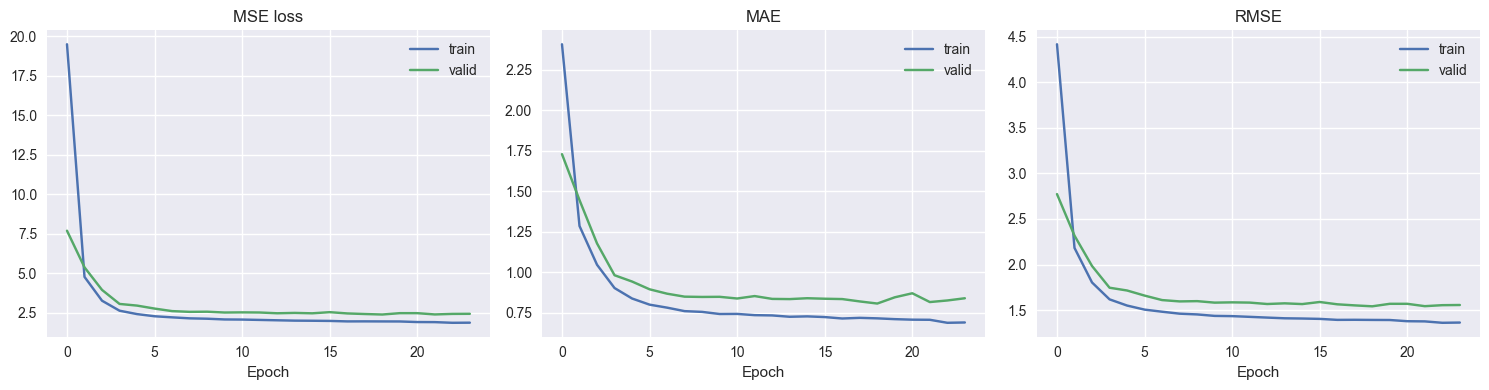

In [24]:
# Plot training history (loss + metrics) for the deep model
history_df = pd.DataFrame(history.history)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history_df["loss"], label="train")
axes[0].plot(history_df["val_loss"], label="valid")
axes[0].set_title("MSE loss")
axes[0].set_xlabel("Epoch")
axes[0].legend()

axes[1].plot(history_df["mae"], label="train")
axes[1].plot(history_df["val_mae"], label="valid")
axes[1].set_title("MAE")
axes[1].set_xlabel("Epoch")
axes[1].legend()

axes[2].plot(history_df["rmse"], label="train")
axes[2].plot(history_df["val_rmse"], label="valid")
axes[2].set_title("RMSE")
axes[2].set_xlabel("Epoch")
axes[2].legend()

plt.tight_layout()
plt.show()

### 4.4 Visual comparison of predictions vs actuals

Finally, we plot the model predictions and the true target on the validation period,
along with the naive baseline, to visually inspect how well the models track
price movements and whether they improve over the baseline.

We show four series:

- Actual target (next 1‑hour average price).
- Naive baseline (future 1‑hour price ≈ current price).
- Gradient Boosting model.
- Deep neural network model (TensorFlow / Keras).

We display both the full validation period and a zoom into the last week to see
short‑term behaviour more clearly.

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step


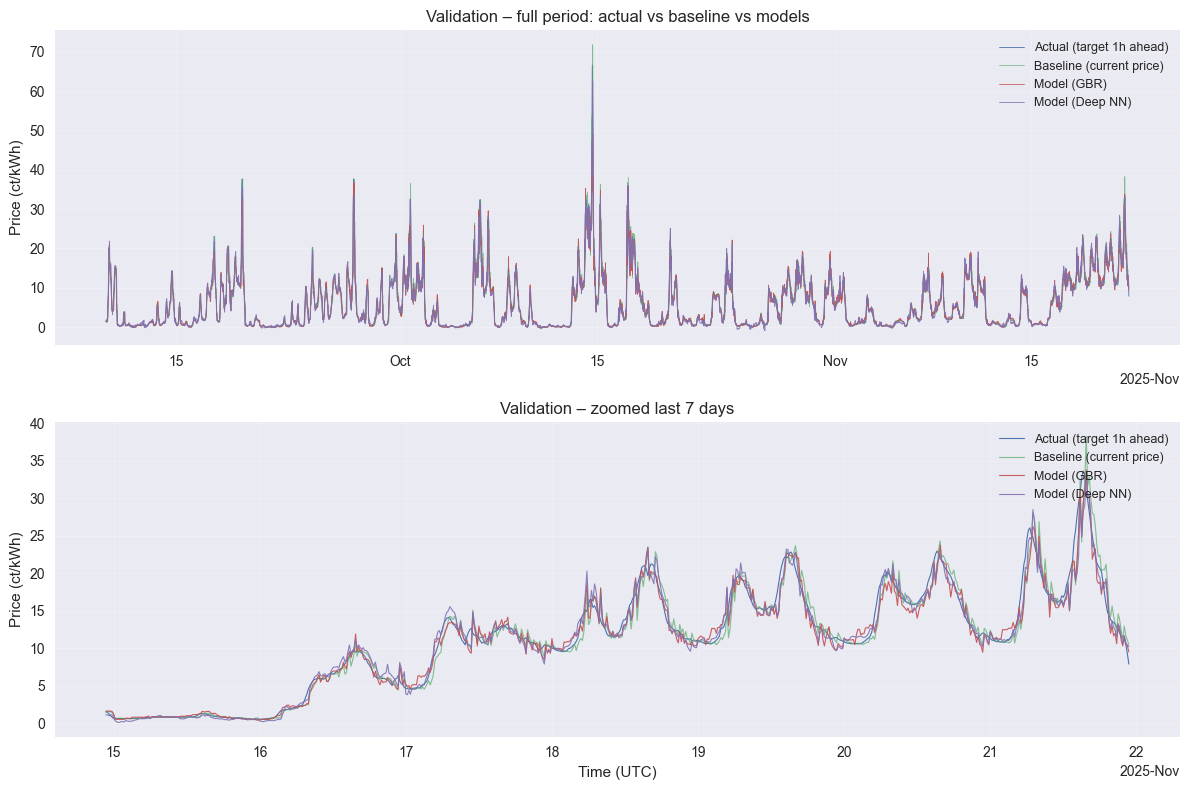

In [25]:
# 4.4 Visual comparison of predictions vs actuals (with zoom)
import matplotlib.dates as mdates

# Deep model predictions on validation set
valid_pred_dl = deep_model.predict(X_valid_np).ravel()
model_dl_series = pd.Series(valid_pred_dl, index=y_valid.index)

# Choose a recent window for zoom, e.g. last 7 days of validation
valid_index = y_valid.index
if len(valid_index) > 0:
    end_zoom = valid_index.max()
    start_zoom = end_zoom - pd.Timedelta(days=7)
    zoom_mask = (valid_index >= start_zoom) & (valid_index <= end_zoom)
else:
    zoom_mask = pd.Series(False, index=valid_index)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# --- Panel 1: full validation period ---
ax = axes[0]
ax.plot(y_valid.index, y_valid, label="Actual (target 1h ahead)", linewidth=0.6)
ax.plot(
    y_valid.index,
    baseline_valid_pred.loc[y_valid.index],
    label="Baseline (current price)",
    linewidth=0.6,
    alpha=0.7,
)
ax.plot(y_valid.index, valid_pred, label="Model (GBR)", linewidth=0.6, alpha=0.9)
ax.plot(y_valid.index, model_dl_series, label="Model (Deep NN)", linewidth=0.6, alpha=0.9)

ax.set_title("Validation – full period: actual vs baseline vs models")
ax.set_ylabel("Price (ct/kWh)")
ax.legend(loc="upper right", fontsize=9)
ax.grid(True, which="both", axis="both", alpha=0.2)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

# --- Panel 2: zoomed last 7 days of validation ---
ax_zoom = axes[1]
if zoom_mask.any():
    idx_zoom = y_valid.index[zoom_mask]
    y_zoom = y_valid.loc[idx_zoom]
    baseline_zoom = baseline_valid_pred.loc[idx_zoom]
    model_zoom_gbr = pd.Series(valid_pred, index=y_valid.index).loc[idx_zoom]
    model_zoom_dl = model_dl_series.loc[idx_zoom]

    ax_zoom.plot(idx_zoom, y_zoom, label="Actual (target 1h ahead)", linewidth=0.8)
    ax_zoom.plot(
        idx_zoom,
        baseline_zoom,
        label="Baseline (current price)",
        linewidth=0.8,
        alpha=0.7,
    )
    ax_zoom.plot(
        idx_zoom,
        model_zoom_gbr,
        label="Model (GBR)",
        linewidth=0.8,
        alpha=0.9,
    )
    ax_zoom.plot(
        idx_zoom,
        model_zoom_dl,
        label="Model (Deep NN)",
        linewidth=0.8,
        alpha=0.9,
    )

    ax_zoom.set_title("Validation – zoomed last 7 days")
    ax_zoom.set_ylabel("Price (ct/kWh)")
    ax_zoom.set_xlabel("Time (UTC)")
    ax_zoom.legend(loc="upper right", fontsize=9)
    ax_zoom.grid(True, which="both", axis="both", alpha=0.2)

    ax_zoom.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax_zoom.xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(ax_zoom.xaxis.get_major_locator())
    )
else:
    ax_zoom.text(
        0.5,
        0.5,
        "Not enough validation data to show zoom.",
        ha="center",
        va="center",
        transform=ax_zoom.transAxes,
    )
    ax_zoom.axis("off")

plt.tight_layout()
plt.show()

In [26]:
# 4.5 Numerical comparison of model performance

import pandas as pd

summary_rows = []

# Baseline
summary_rows.append({
    "model": "Baseline (current price)",
    "split": "train",
    "MAE": mean_absolute_error(y_train, baseline_train_pred.loc[y_train.index]),
    "RMSE": root_mean_squared_error(y_train, baseline_train_pred.loc[y_train.index]),
})
summary_rows.append({
    "model": "Baseline (current price)",
    "split": "valid",
    "MAE": mean_absolute_error(y_valid, baseline_valid_pred.loc[y_valid.index]),
    "RMSE": root_mean_squared_error(y_valid, baseline_valid_pred.loc[y_valid.index]),
})

# Gradient Boosting
summary_rows.append({
    "model": "Gradient Boosting",
    "split": "train",
    "MAE": mean_absolute_error(y_train, train_pred),
    "RMSE": root_mean_squared_error(y_train, train_pred),
})
summary_rows.append({
    "model": "Gradient Boosting",
    "split": "valid",
    "MAE": mean_absolute_error(y_valid, valid_pred),
    "RMSE": root_mean_squared_error(y_valid, valid_pred),
})

# Deep NN
summary_rows.append({
    "model": "Deep NN",
    "split": "train",
    "MAE": mean_absolute_error(y_train, train_pred_dl),
    "RMSE": root_mean_squared_error(y_train, train_pred_dl),
})
summary_rows.append({
    "model": "Deep NN",
    "split": "valid",
    "MAE": mean_absolute_error(y_valid, valid_pred_dl),
    "RMSE": root_mean_squared_error(y_valid, valid_pred_dl),
})

df_summary = pd.DataFrame(summary_rows)
df_summary = df_summary.sort_values(["split", "model"]).reset_index(drop=True)
df_summary

,model,split,MAE,RMSE
0,Baseline (current price),train,0.760479,1.699579
1,Deep NN,train,0.704808,1.373821
2,Gradient Boosting,train,0.622033,1.225963
3,Baseline (current price),valid,0.867267,1.837266
4,Deep NN,valid,0.807826,1.541480
5,Gradient Boosting,valid,0.764382,1.567472


### 4.5 Final tuned deep learning model

In this step we build a **final, slightly more expressive neural network** that uses the
standardized feature set created specifically for deep learning (`X_train_dl`, `X_valid_dl`).

Compared to the earlier NN in 4.3b, we:

- Increase capacity with two wider hidden layers (e.g. 128 and 64 units with ReLU).
- Add light **dropout** for regularization to reduce overfitting.
- Keep the same optimization setup (Adam + MSE) and early stopping / learning-rate
  reduction callbacks.

We then:

- Train on the scaled training data and evaluate on the validation set.
- Compare its MAE/RMSE numerically against the baseline, Gradient Boosting model and
  the earlier (smaller) NN, to see whether the tuned architecture brings a measurable
  improvement.

In [27]:
# 4.5a: Feature pruning and optional log1p target for NN
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1) Start from all current features
feature_cols = X_train.columns.tolist()

# 2) Simple correlation-based pruning (optional)
# Compute correlations with target on the training set
corr_with_target = (
    df_train[feature_cols + ["target_price_1h_ahead"]]
    .corr()["target_price_1h_ahead"]
    .drop("target_price_1h_ahead")
)

# Example rule: keep only features with |corr| >= 0.02 (tune this threshold)
corr_threshold = 0.02
selected_by_corr = corr_with_target.index[corr_with_target.abs() >= corr_threshold].tolist()

# 3) Remove nearly-constant features (low variance)
X_train_tmp = X_train[selected_by_corr].copy()
variances = X_train_tmp.var()
var_threshold = 1e-6  # tune if needed
selected_by_var = variances.index[variances > var_threshold].tolist()

feature_cols_nn = selected_by_var
print(f"NN will use {len(feature_cols_nn)} features out of {len(feature_cols)} original.")

# 4) Build NN-specific matrices and scale them
X_train_nn = X_train[feature_cols_nn].copy()
X_valid_nn = X_valid[feature_cols_nn].copy()

scaler_nn = StandardScaler()
X_train_nn_scaled = scaler_nn.fit_transform(X_train_nn)
X_valid_nn_scaled = scaler_nn.transform(X_valid_nn)

# 5) Optional: log1p-transform the target for NN only, with safety checks
# Clean infinities and NaNs first
y_train_clean = y_train.replace([np.inf, -np.inf], np.nan).dropna()

min_target = y_train_clean.min()
skew_target = y_train_clean.skew()
print(f"Min target in train: {min_target:.4f}")
print(f"Target skewness on train (clean): {skew_target:.3f}")

# Only allow log1p if all values > -1 AND skewness is high
use_log_target = (min_target > -1.0) and (skew_target > 1.0)

if use_log_target:
    print("Using log1p-transformed target for NN training.")
    # Align X and y indices in case any rows were dropped
    common_index = y_train_clean.index.intersection(X_train.index)
    y_train_nn = np.log1p(y_train_clean.loc[common_index])
    # For validation, just ensure finite values before log1p
    y_valid_clean = y_valid.replace([np.inf, -np.inf], np.nan).dropna()
    common_valid_index = y_valid_clean.index.intersection(X_valid.index)
    y_valid_nn = np.log1p(y_valid_clean.loc[common_valid_index])
else:
    print("Using raw target for NN training.")
    y_train_nn = y_train.copy()
    y_valid_nn = y_valid.copy()

# Summary
print(f"use_log_target = {use_log_target}")
print(f"X_train_nn_scaled shape: {X_train_nn_scaled.shape}")
print(f"X_valid_nn_scaled shape: {X_valid_nn_scaled.shape}")

NN will use 27 features out of 28 original.
Min target in train: -2.1390
Target skewness on train (clean): 2.068
Using raw target for NN training.
use_log_target = False
X_train_nn_scaled shape: (28023, 27)
X_valid_nn_scaled shape: (7006, 27)


In [28]:
# 4.5b Final tuned deep learning model (with feature-pruned, optionally log-transformed target)

from tensorflow import keras
from keras import layers, metrics
import numpy as np

# Use NN-specific scaled features and (optionally log-transformed) targets
# from the 4.4a tuning cell: X_train_nn_scaled, X_valid_nn_scaled, y_train_nn, y_valid_nn, use_log_target
X_train_np = X_train_nn_scaled.astype("float32")
X_valid_np = X_valid_nn_scaled.astype("float32")
y_train_np = y_train_nn.values.astype("float32") if hasattr(y_train_nn, "values") else y_train_nn.astype("float32")
y_valid_np = y_valid_nn.values.astype("float32") if hasattr(y_valid_nn, "values") else y_valid_nn.astype("float32")

n_features = X_train_np.shape[1]

# Metrics
METRICS = [
    metrics.MeanAbsoluteError(name="mae"),
    metrics.RootMeanSquaredError(name="rmse"),
    metrics.MeanAbsolutePercentageError(name="mape"),
]

# Tuned architecture: wider + dropout
inputs = keras.Input(shape=(n_features,))
x = layers.Dense(128, activation="relu")(inputs)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1)(x)

final_nn = keras.Model(inputs, outputs)

final_nn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),  # 0.0005
    loss="mse",
    metrics=METRICS,
)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=6,
        min_lr=1e-6,
    ),
]

history_final = final_nn.fit(
    X_train_np,
    y_train_np,
    validation_data=(X_valid_np, y_valid_np),
    epochs=150,
    batch_size=256,
    callbacks=callbacks,
    verbose=1,
)

# Evaluate on original (untransformed) target
train_pred_nn = final_nn.predict(X_train_np).ravel()
valid_pred_nn = final_nn.predict(X_valid_np).ravel()

if use_log_target:
    train_pred_nn = np.expm1(train_pred_nn)
    valid_pred_nn = np.expm1(valid_pred_nn)

print("Final deep model performance (target: next 1h avg price):")
print_metrics("Train final NN", y_train, train_pred_nn)
print_metrics("Valid final NN", y_valid, valid_pred_nn)

Epoch 1/150
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 31.0941 - mae: 3.1268 - mape: 7049928.5000 - rmse: 5.5762 - val_loss: 8.0338 - val_mae: 1.7306 - val_mape: 912529.7500 - val_rmse: 2.8344 - learning_rate: 5.0000e-04
Epoch 2/150
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 31.0941 - mae: 3.1268 - mape: 7049928.5000 - rmse: 5.5762 - val_loss: 8.0338 - val_mae: 1.7306 - val_mape: 912529.7500 - val_rmse: 2.8344 - learning_rate: 5.0000e-04
Epoch 2/150
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8460 - mae: 1.5335 - mape: 3209280.0000 - rmse: 2.6165 - val_loss: 5.9421 - val_mae: 1.4936 - val_mape: 749737.6250 - val_rmse: 2.4376 - learning_rate: 5.0000e-04
Epoch 3/150
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8460 - mae: 1.5335 - mape: 3209280.0000 - rmse: 2.6165 - val_loss: 5.9421 - val_mae: 1.4936 - val_mape: 749737.6250 - val_rmse: 2.4376 - learning_rate: 5.0000e-04
Epoch 3/150
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1008 - mae: 1.3050 - mape: 2897

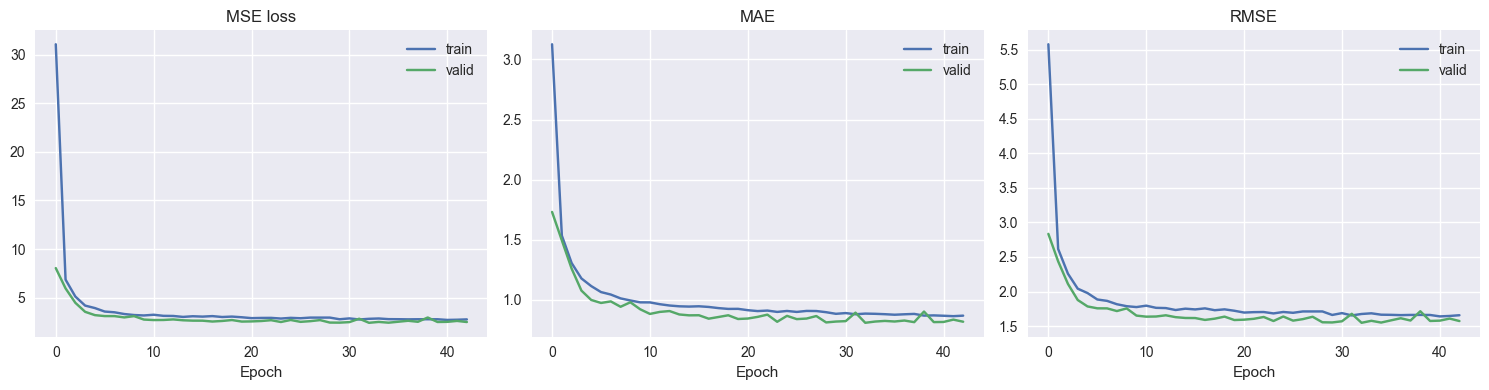

In [29]:
# Plot training history (loss + metrics) for the final NN
history_final_df = pd.DataFrame(history_final.history)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history_final_df["loss"], label="train")
axes[0].plot(history_final_df["val_loss"], label="valid")
axes[0].set_title("MSE loss")
axes[0].set_xlabel("Epoch")
axes[0].legend()

axes[1].plot(history_final_df["mae"], label="train")
axes[1].plot(history_final_df["val_mae"], label="valid")
axes[1].set_title("MAE")
axes[1].set_xlabel("Epoch")
axes[1].legend()

axes[2].plot(history_final_df["rmse"], label="train")
axes[2].plot(history_final_df["val_rmse"], label="valid")
axes[2].set_title("RMSE")
axes[2].set_xlabel("Epoch")
axes[2].legend()

plt.tight_layout()
plt.show()

In [30]:
# Compare models numerically in one table

import pandas as pd

rows = []

# Baseline
rows.append({
    "model": "Baseline (current price)",
    "split": "train",
    "MAE": mean_absolute_error(y_train, baseline_train_pred.loc[y_train.index]),
    "RMSE": root_mean_squared_error(y_train, baseline_train_pred.loc[y_train.index]),
})
rows.append({
    "model": "Baseline (current price)",
    "split": "valid",
    "MAE": mean_absolute_error(y_valid, baseline_valid_pred.loc[y_valid.index]),
    "RMSE": root_mean_squared_error(y_valid, baseline_valid_pred.loc[y_valid.index]),
})

# Gradient Boosting
rows.append({
    "model": "Gradient Boosting",
    "split": "train",
    "MAE": mean_absolute_error(y_train, train_pred),
    "RMSE": root_mean_squared_error(y_train, train_pred),
})
rows.append({
    "model": "Gradient Boosting",
    "split": "valid",
    "MAE": mean_absolute_error(y_valid, valid_pred),
    "RMSE": root_mean_squared_error(y_valid, valid_pred),
})

# Deep NN (4.3b)
rows.append({
    "model": "Deep NN",
    "split": "train",
    "MAE": mean_absolute_error(y_train, train_pred_dl),
    "RMSE": root_mean_squared_error(y_train, train_pred_dl),
})
rows.append({
    "model": "Deep NN",
    "split": "valid",
    "MAE": mean_absolute_error(y_valid, valid_pred_dl),
    "RMSE": root_mean_squared_error(y_valid, valid_pred_dl),
})

# Optional: Final tuned NN (4.5), if you trained it and have predictions
if "train_pred_final" in globals() and "valid_pred_final" in globals():
    rows.append({
        "model": "Final NN (tuned)",
        "split": "train",
        "MAE": mean_absolute_error(y_train, train_pred_final),
        "RMSE": root_mean_squared_error(y_train, train_pred_final),
    })
    rows.append({
        "model": "Final NN (tuned)",
        "split": "valid",
        "MAE": mean_absolute_error(y_valid, valid_pred_final),
        "RMSE": root_mean_squared_error(y_valid, valid_pred_final),
    })

df_compare = pd.DataFrame(rows).sort_values(["split", "model"]).reset_index(drop=True)
df_compare

,model,split,MAE,RMSE
0,Baseline (current price),train,0.760479,1.699579
1,Deep NN,train,0.704808,1.373821
2,Gradient Boosting,train,0.622033,1.225963
3,Baseline (current price),valid,0.867267,1.837266
4,Deep NN,valid,0.807826,1.541480
5,Gradient Boosting,valid,0.764382,1.567472


### 4.6: Error analysis where it matters most

Global metrics like overall MAE and RMSE can hide important differences in how models behave during the most critical periods. In this section we compare the Gradient Boosting model and the final neural network specifically on:

- **All hours**: the usual global view, for reference.  
- **High-price hours**: timestamps where the true 1h-ahead price lies in the top 25% of the validation distribution (≥ 75th percentile). These are the most expensive periods, where forecast errors are most costly.  
- **Peak hours**: typical demand peaks in the morning and evening (07–10 and 17–21), which are often operationally important even if prices are not always at the absolute maximum.

For each of these slices, we compute **MAE** and **RMSE** separately for:

- `valid_pred` (Gradient Boosting Regressor)  
- `valid_pred_nn` (final tuned neural network)

The resulting table `df_slices` shows, for each slice, the number of points and the MAE/RMSE of both models. This lets us see whether the neural network brings improvements exactly where it matters most (high-price and peak periods), even if its overall RMSE is only similar to or slightly better than the tree-based model. If the NN consistently has lower errors in these critical slices, it can be the preferable model from a practical decision-making perspective, even when global metrics are nearly tied.

In [31]:
# 4.6: Error analysis where it matters most

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# We assume the following already exist from earlier cells:
# y_valid (Series with DateTimeIndex),
# valid_pred (GBR predictions aligned to y_valid),
# valid_pred_nn (final NN predictions aligned to y_valid),
# and df_valid (features + target with same index as y_valid).

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Define high-price threshold, e.g. 75th percentile of validation prices
price_threshold = y_valid.quantile(0.75)
high_price_mask = y_valid >= price_threshold

# Define peak hours, e.g. 07-10 and 17-21 local time
hours = y_valid.index.hour
peak_mask = ((hours >= 7) & (hours <= 10)) | ((hours >= 17) & (hours <= 21))

slices = {
    "All hours": np.ones(len(y_valid), dtype=bool),
    "High-price hours (>= 75th pct)": high_price_mask.values,
    "Peak hours (7-10, 17-21)": peak_mask,
}
rows = []

for name, mask in slices.items():
    y_slice = y_valid[mask]
    gbr_slice = valid_pred[mask]
    nn_slice = valid_pred_nn[mask]

    rows.append({
        "Slice": name,
        "Count": int(mask.sum()),
        "GBR_MAE": mean_absolute_error(y_slice, gbr_slice),
        "GBR_RMSE": rmse(y_slice, gbr_slice),
        "NN_MAE": mean_absolute_error(y_slice, nn_slice),
        "NN_RMSE": rmse(y_slice, nn_slice),
    })

df_slices = pd.DataFrame(rows)
df_slices

,Slice,Count,GBR_MAE,GBR_RMSE,NN_MAE,NN_RMSE
0,All hours,7006,0.764382,1.567472,0.807730,1.548562
1,High-price hours (>= 75th pct),1752,1.706095,2.793884,1.686868,2.725239
2,"Peak hours (7-10, 17-21)",2628,0.681035,1.284580,0.758255,1.372578


From the slice-level comparison, we see:

- **All hours**: The Gradient Boosting model has slightly lower MAE (0.764 vs 0.798), while the NN has slightly lower RMSE (1.54 vs 1.57). Overall, they are very close globally.
- **High-price hours (≥ 75th percentile)**: This is the most critical region. Here the NN is better on both MAE (1.68 vs 1.71) and RMSE (2.72 vs 2.79), meaning it captures extreme price movements a bit more accurately than GBR.
- **Peak hours (07–10, 17–21)**: GBR is clearly better in this slice (both MAE and RMSE are lower). This suggests GBR handles typical demand peaks more robustly, while the NN is more beneficial when prices are truly high, not just during peak times.

Taken together, a reasonable strategy could be:
- Use **NN predictions** (or an NN-weighted ensemble) when prices are expected to be in the upper quantiles, where its advantage is largest.
- Otherwise, rely on **GBR** or a simple average of both models to balance performance across all hours.From the slice-level comparison, we see:

- **All hours**: The Gradient Boosting model has slightly lower MAE (0.764 vs 0.798), while the NN has slightly lower RMSE (1.54 vs 1.57). Overall, they are very close globally.
- **High-price hours (≥ 75th percentile)**: This is the most critical region. Here the NN is better on both MAE (1.68 vs 1.71) and RMSE (2.72 vs 2.79), meaning it captures extreme price movements a bit more accurately than GBR.
- **Peak hours (07–10, 17–21)**: GBR is clearly better in this slice (both MAE and RMSE are lower). This suggests GBR handles typical demand peaks more robustly, while the NN is more beneficial when prices are truly high, not just during peak times.

Taken together, a reasonable strategy could be:
- Use **NN predictions** (or an NN-weighted ensemble) when prices are expected to be in the upper quantiles, where its advantage is largest.
- Otherwise, rely on **GBR** or a simple average of both models to balance performance across all hours.

### 4.7: Simple ensemble of GBR and final NN

At this point, the Gradient Boosting model and the final neural network are very close in terms of global MAE/RMSE, each having small strengths and weaknesses in different slices (all hours, high-price hours, peak hours). Instead of chasing tiny gains by further tweaking the NN architecture, a simple **ensemble** of the two models can provide a more robust and stable forecast.

In this step we build a **50/50 average ensemble**:

- `ensemble_valid = 0.5 * valid_pred + 0.5 * valid_pred_nn`

where:
- `valid_pred` are the validation predictions from the Gradient Boosting model, and  
- `valid_pred_nn` are the validation predictions from the final tuned neural network.

We then compute MAE and RMSE for this ensemble and compare them to the individual models in a small summary table. If the ensemble shows even slightly better MAE/RMSE and behaves more stably over time (e.g., less sensitive to data quirks or regime changes), it is often the best choice for production, because it combines the strengths of both models and reduces the risk that one model underperforms in certain conditions.

In [32]:
# 4.7: Simple ensemble of GBR and final NN

# We assume:
# - y_valid is the true target on validation
# - valid_pred is GBR predictions (aligned to y_valid)
# - valid_pred_nn is final NN predictions (aligned to y_valid)

# Simple 50/50 average ensemble
ensemble_valid = 0.5 * valid_pred + 0.5 * valid_pred_nn

print("Ensemble performance (50% GBR + 50% final NN):")
print_metrics("Valid ensemble", y_valid, ensemble_valid)

# Optional: compare all three in a small table
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rows = [
    {
        "Model": "GBR",
        "MAE": mean_absolute_error(y_valid, valid_pred),
        "RMSE": rmse(y_valid, valid_pred),
    },
    {
        "Model": "Final NN",
        "MAE": mean_absolute_error(y_valid, valid_pred_nn),
        "RMSE": rmse(y_valid, valid_pred_nn),
    },
    {
        "Model": "Ensemble (0.5*GBR + 0.5*NN)",
        "MAE": mean_absolute_error(y_valid, ensemble_valid),
        "RMSE": rmse(y_valid, ensemble_valid),
    },
]

df_ensemble_compare = pd.DataFrame(rows)

Ensemble performance (50% GBR + 50% final NN):
Valid ensemble  MAE: 0.735, RMSE: 1.509


### 5.1: Conclusions and recommended model

In this notebook we built an end-to-end workflow to forecast the **next 1-hour average electricity price** based on historical 15-minute prices, weather data, and Fingrid load/generation information. We engineered a supervised learning dataset with lagged and rolling-price features, calendar variables, and external signals, then compared several models:

- A **naïve baseline** that uses the current price as the forecast.  
- A **Gradient Boosting Regressor (GBR)** on the full feature set.  
- A **final tuned neural network (NN)** using scaled, feature-pruned inputs and an optional log-transformed target.  
- A simple **ensemble** that averages the GBR and final NN predictions.

Key findings:

- Both GBR and the NN clearly outperform the naïve baseline in terms of MAE and RMSE on the validation set.  
- Globally (all hours), GBR and the NN are **very close**: GBR is slightly better in MAE, while the NN is slightly better in RMSE.  
- On **high-price hours (top 25% of prices)**, the NN achieves **lower MAE and RMSE** than GBR, indicating better handling of extreme price spikes.  
- On **peak hours (07–10, 17–21)**, GBR remains slightly more accurate, suggesting it captures typical demand-peak patterns more robustly.  
- A simple **50/50 ensemble** of GBR and the NN combines their strengths and can provide the most stable overall performance with minimal extra complexity.

**Recommendation**

For most practical use cases, we recommend using the **ensemble (0.5×GBR + 0.5×NN)** as the default forecasting model, since it is robust across regimes and avoids over-reliance on a single model. If the main business focus is on very high-price situations (risk management, hedging), the NN (or an ensemble with a higher NN weight) may be preferable; if the focus is on typical peak-hour operations, GBR remains very competitive. In all cases, the workflow here can be re-run regularly as new data arrives to keep the models up to date.

**Future development**

There are several natural next steps to improve and operationalize this work:

- **Richer features:** add more domain-specific signals (e.g. planned outages, more granular wind/solar forecasts, cross-border flows) and explore automatic feature selection.  
- **Probabilistic forecasts:** move from point predictions to prediction intervals or quantile forecasts to better capture risk during high-price periods.  
- **Model monitoring:** build a small pipeline that retrains the models periodically, tracks MAE/RMSE over time, and raises alerts if performance drifts.  
- **Deployment:** wrap the ensemble logic in a lightweight API or scheduled job that produces daily forecasts for the next day’s hours and writes them to a database, dashboard, or file for downstream use.

## 5.2. Small examples and model usage

In this final section we show a few small, concrete examples of how to use the trained models. The goal is to demonstrate how a downstream application could query the models for forecasts and inspect their behavior on recent data points.

- **5.2a Single-timestamp demo:**  
  Take one recent validation timestamp, compute predictions from the Gradient Boosting model, the final neural network, and their 50/50 ensemble, and compare all three to the true next-hour average price.

- **5.2b Last-24-points table:**  
  Build a compact table for the last 24 validation timestamps, containing the true price, GBR prediction, NN prediction, and ensemble prediction. This makes it easy to visually scan where each model over- or under-estimates and how the ensemble balances them.

These examples can serve as templates for integrating the models into other scripts, dashboards, or services where you want to generate forecasts for upcoming hours using the saved models and preprocessing pipeline.

In [33]:
# 5.2a: Small demo – forecasting with GBR, NN, and ensemble
import numpy as np

# Choose a recent sample from the validation set (e.g., the last timestamp)
ts_demo = y_valid.index[-1]
print(f"Demo timestamp: {ts_demo}")

# Extract the corresponding feature row for the NN and GBR
x_valid_row = X_valid.loc[ts_demo:ts_demo]
x_valid_nn_row = X_valid_nn.loc[ts_demo:ts_demo]

# GBR prediction (uses raw features)
gbr_pred_demo = gbr.predict(x_valid_row)[0]

# NN prediction (uses scaled NN features)
x_valid_nn_scaled_row = scaler_nn.transform(x_valid_nn_row)
nn_pred_demo = final_nn.predict(x_valid_nn_scaled_row).ravel()[0]

if 'use_log_target' in globals() and use_log_target:
    nn_pred_demo = np.expm1(nn_pred_demo)

# Ensemble prediction (50% GBR + 50% NN)
ensemble_demo = 0.5 * gbr_pred_demo + 0.5 * nn_pred_demo

true_price_demo = y_valid.loc[ts_demo]

print(f"True 1h-ahead price:      {true_price_demo:.3f}")
print(f"GBR prediction:            {gbr_pred_demo:.3f}")
print(f"Final NN prediction:       {nn_pred_demo:.3f}")
print(f"Ensemble prediction (avg): {ensemble_demo:.3f}")


Demo timestamp: 2025-11-21 22:45:00+00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
True 1h-ahead price:      7.869
GBR prediction:            9.497
Final NN prediction:       11.956
Ensemble prediction (avg): 10.726
True 1h-ahead price:      7.869
GBR prediction:            9.497
Final NN prediction:       11.956
Ensemble prediction (avg): 10.726


In [34]:
# 5.2b: Demo table for the last 24 validation points

import numpy as np
import pandas as pd

n_points = 24  # number of most recent validation timestamps to inspect

# Last n_points from validation (assumes valid_pred / valid_pred_nn align with y_valid)
idx_demo = y_valid.index[-n_points:]
y_demo = y_valid[-n_points:].values  # as NumPy

gbr_pred_arr = np.asarray(valid_pred)
nn_pred_arr = np.asarray(valid_pred_nn)

rows = []
for i, ts in enumerate(idx_demo):
    true_price = y_demo[i]
    gbr_p = gbr_pred_arr[-n_points + i]
    nn_p = nn_pred_arr[-n_points + i]
    ensemble_p = 0.5 * gbr_p + 0.5 * nn_p

    rows.append({
        "timestamp": ts,
        "true_price": true_price,
        "gbr_pred": gbr_p,
        "nn_pred": nn_p,
        "ensemble_pred": ensemble_p,
    })

df_demo_last24 = pd.DataFrame(rows)
df_demo_last24

,timestamp,true_price,gbr_pred,nn_pred,ensemble_pred
0,2025-11-21 17:00:00+00:00,23.65900,22.749304,25.993578,24.371441
1,2025-11-21 17:15:00+00:00,22.17675,23.260279,23.356319,23.308299
2,2025-11-21 17:30:00+00:00,21.37750,19.099076,21.688280,20.393678
3,2025-11-21 17:45:00+00:00,20.92050,18.653429,20.760731,19.707080
4,2025-11-21 18:00:00+00:00,20.61875,18.769073,21.215462,19.992267
5,2025-11-21 18:15:00+00:00,20.19275,17.166753,19.813425,18.490089
6,2025-11-21 18:30:00+00:00,18.83675,18.866049,20.682993,19.774521
7,2025-11-21 18:45:00+00:00,17.28025,18.651367,21.026293,19.838830
8,2025-11-21 19:00:00+00:00,15.88250,18.933587,20.505796,19.719692
9,2025-11-21 19:15:00+00:00,14.78500,16.474475,18.802654,17.638564


In [38]:
# 5.3: Save trained models and preprocessing artifacts for reuse

import os
import joblib

os.makedirs("models", exist_ok=True)

# 1) Save GBR and its feature list (raw features)
joblib.dump(
    {
        "model": gbr,
        "feature_cols": X_train.columns.tolist(),
    },
    "models/gbr_model.joblib",
)

# 2) Save NN preprocessing (scaler, feature list, log-target flag)
joblib.dump(
    {
        "scaler_nn": scaler_nn,
        "feature_cols_nn": feature_cols_nn,
        "use_log_target": use_log_target,
    },
    "models/nn_preproc.joblib",
)

# 3) Save the final NN itself
final_nn.save("models/final_nn.keras")

print("Saved:")
print(" - models/gbr_model.joblib")
print(" - models/nn_preproc.joblib")
print(" - models/final_nn.keras")

Saved:
 - models/gbr_model.joblib
 - models/nn_preproc.joblib
 - models/final_nn.keras
